# Kaggle Mini Project - Generative Adversarial Networks - GANs

## 1. Project Description

In this project, we aim to create a Generative Adversarial Network (GAN) that generates Monet-style images. The GAN architecture involves two neural networks - a generator and a discriminator, which work against each other in a competitive setting.

The generator is responsible for generating images in the style of Monet. To achieve this, I will provide the generator with a dataset of Monet paintings. The generator will learn from this dataset to produce new images that resemble the Monet style. The discriminator's role is to evaluate whether the generated images are real or fake. It receives input from both the generator and a set of real Monet paintings. The discriminator then determines whether an image is a genuine Monet painting or a generated image.

During the training process, the generator and discriminator are pitted against each other. The generator tries to produce images that can fool the discriminator, while the discriminator tries to correctly classify real and generated images. This competition results in the generator producing increasingly more realistic images in the style of Monet.

As I train the GAN, I will monitor its monitor the generator and discriminator loss during training to ensure that the GAN is converging to a stable solution. The generator loss should decrease over time, while the discriminator loss should oscillate around a stable value.

Once I have the final model, it will be submitted to the Kaggle competition to evaluate how well I did relative to other participants. Kaggle uses the MiFID score, which is a measure of the similarity between two sets of images. This will be calculated once the results are submitted.

**Notes and References:**
> * I adapted much of the code from Amy Jang's tutorial. In the respective sections of the code, I have provided details of the optimizations and changes that I have made. 
> * Link to Amy Jang's tutorial: https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial/notebook
> * Link to the Kaggle competition: https://www.kaggle.com/competitions/gan-getting-started

### 1.1 - Decription of Generative Deep Learning Models

Generative deep learning models are a type of artificial intelligence (AI) that involves generating new data that is similar to the training data. They are used for tasks such as image generation, music generation, and text generation.

Generative models use a deep neural network architecture, which is a type of machine learning model that consists of multiple layers of interconnected nodes. These nodes are able to learn patterns and features from the input data and use this information to make predictions.

There are two main types of generative models:

* **Variational Autoencoders (VAEs)**: VAEs are neural networks that learn to encode and decode images or other types of data. They are used to generate new data that is similar to the training data. VAEs work by learning a probabilistic distribution of the input data and then generating new samples by sampling from this distribution.

* **Generative Adversarial Networks (GANs)**: GANs consist of two neural networks: a generator and a discriminator. The generator generates new data samples, while the discriminator evaluates whether these samples are real or fake. The two networks are trained together in a competitive setting, with the generator trying to produce more realistic samples and the discriminator trying to correctly identify the real samples. This competition results in the generator being able to produce highly realistic samples.

Generative deep learning models have many practical applications, such as generating new images or videos, generating new music, and generating realistic human-like conversations.

In [1]:
# Install tensorflow_addons library to be used in Google's Colab
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 4.6 MB/s eta 0:00:00


In [3]:
# Attempt to initialize a TPU cluster
try:
    # Connect to the TPU cluster and initialize the TPU system
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)

    # Define a TPU strategy for distributed training
    strategy = tf.distribute.TPUStrategy(tpu)
    runtime = 'TPU'

# If TPU initialization fails, use default strategy (GPU)
except:
    strategy = tf.distribute.get_strategy()
    runtime = 'GPU'

print('Number of replicas:', strategy.num_replicas_in_sync)

# Define AUTOTUNE as tf.data.experimental.AUTOTUNE for optimal performance
AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)
print(runtime)

Device: grpc://10.79.110.58:8470
Number of replicas: 8
2.12.0
TPU


## 2 - Data Description and Data Load

The dataset for this project/competition consists of four directories: monet_tfrec, photo_tfrec, monet_jpg, and photo_jpg. The directories monet_tfrec and monet_jpg contain identical sets of Monet paintings, while the photo_tfrec and photo_jpg directories contain the same collection of photos.

The Monet directories, whether in TFRecord or JPEG format, are the ones that contain the paintings that should be used for training the model.

**Files:**
* monet_jpg - 300 Monet paintings sized 256x256 in JPEG format, each photo in 1 file
* monet_tfrec - 300 Monet paintings sized 256x256 in TFRecord format in 5 files
* photo_jpg - 7028 photos sized 256x256 in JPEG format, each photo in 1 file
* photo_tfrec - 7028 photos sized 256x256 in TFRecord format in 20 files

Each image in the dataset is in RGB format, which means that it contains 3 color channels: red, green, and blue.

I will be using TFRecords instead of the individual JPEG images. There are several advantages to using TFRecords instead of individual image files when working with large datasets in deep learning:

* Faster Data Loading: Reading and decoding individual image files can be slow and resource-intensive, especially when working with large datasets. By using TFRecords, we can optimize the data loading process and significantly speed up the training process.

* Efficient Storage: TFRecords are a compact and efficient way to store large amounts of data. They can be compressed and indexed to allow for fast and efficient access to individual records within the file.

* Streamlined Data Pipeline: Working with TFRecords enables us to streamline the data pipeline and perform operations such as shuffling, batching, and preprocessing on the data without having to read the entire dataset into memory.

* Better Performance on Distributed Systems: When working with distributed systems, such as those that use Tensor Processing Units (TPUs), using TFRecords can result in better performance and more efficient use of resources.

### 2.1 - Function to decode image and read TFRecords

Images are often encoded in a compressed format such as JPEG or PNG to reduce their size for storage and transmission. Before an image can be used in a deep learning model, it needs to be decoded or decompressed. Decoding converts the compressed image format to a raw pixel format that can be used as input to a model. 

In addition, decoding can also apply preprocessing steps such as resizing, normalization, and color space conversion to the image before it is used in the model. Therefore, in the case of the given code, the function decode_image is used to decode the JPEG-encoded image by converting it from its compressed form to a tensor of raw pixel values that can be used for training a deep learning model.

The **decode_image** function takes an image as input and performs the following operations on it:

* Decodes the image from JPEG format with 3 color channels using tf.image.decode_jpeg function.
* Casts the pixel values to float32 and normalizes them to the range [-1, 1] by dividing them with 127.5 and then subtracting 1.
* Reshapes the image tensor to the desired size by using tf.reshape function.

The **read_tfrecord** function is used to read and parse a single example from the input TFRecord. It takes an example as input and performs the following operations on it:

* Defines the expected format of each feature in the TFRecord using the tfrecord_format dictionary.
* Parses the input example using tf.io.parse_single_example function and the expected format defined in the tfrecord_format dictionary.
* Decodes the image tensor from the parsed example using the decode_image function.

In [4]:
# Define function to decode image
def decode_image(image):

    # Decode image in JPEG format with 3 color channels
    image = tf.image.decode_jpeg(image, channels=3)

    # Cast the pixel values to float32 and normalize to [-1, 1]
    image = (tf.cast(image, tf.float32) / 127.5) - 1

    # Reshape the image tensor to the desired size
    image = tf.reshape(image, [*IMAGE_SIZE, 3])

    return image

# Define function to read TFRecord examples
def read_tfrecord(example):

    # Define the expected format of each feature in the TFRecord
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }

    # Parse a single example from the input TFRecord using the expected format
    example = tf.io.parse_single_example(example, tfrecord_format)
    # Decode the image tensor from the TFRecord using the decode_image function
    image = decode_image(example['image'])

    return image


### 2.2 - Data Load

To facilitate the use of TPUs on Google's Colab platform, the dataset will be loaded directly from Kaggle's Google Cloud Storage (GCS) location.

In [5]:
# Set data path
# DATA_PATH = 'gs://kds-e6271be81b423c831756f2d3fb91898695220116d9718a28f7fbd49a'
DATA_PATH = 'gs://kds-7477d57c94a6f62a7a422c2bc93a7825035e2e9a3ab0164188ccafe6'

# Load files
MONET_FILENAMES = tf.io.gfile.glob(str(DATA_PATH + '/monet_tfrec/*.tfrec'))
PHOTO_FILENAMES = tf.io.gfile.glob(str(DATA_PATH + '/photo_tfrec/*.tfrec'))

# Define image size
IMAGE_SIZE = [256, 256]

# Define image batch size
BATCH_SIZE = 1

# Define buffer size for shuffling
BUFFER_SIZE = 10000

print('Number of Monet TFRecord Files:', len(MONET_FILENAMES))
print('Number of Photo TFRecord Files:', len(PHOTO_FILENAMES))

Number of Monet TFRecord Files: 5
Number of Photo TFRecord Files: 20


In [6]:
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)

    # Shuffle and batch the dataset
    dataset = dataset.shuffle(BUFFER_SIZE)
    return dataset

# Load the photo and Monet datasets
monet_dataset = load_dataset(MONET_FILENAMES, labeled=True).batch(BATCH_SIZE)
photo_dataset = load_dataset(PHOTO_FILENAMES, labeled=True).batch(BATCH_SIZE)

example_monet = next(iter(monet_dataset))
example_photo = next(iter(photo_dataset))

# Load the photo and Monet datasets
monet_dataset = load_dataset(MONET_FILENAMES, labeled=True).batch(BATCH_SIZE)
photo_dataset = load_dataset(PHOTO_FILENAMES, labeled=True).batch(BATCH_SIZE)

## 3 - Exploratory Data Analysis - EDA

Exploratory data analysis (EDA) on images is an important step in understanding the characteristics and properties of the dataset. EDA allows us to visualize and analyze the distribution, quality, and complexity of the images in the dataset. Although there is no fixed or standard procedure for conducting EDA on images, a basic approach is to select a few samples of images from each class, display them, and describe any findings.

This initial inspection of the images can reveal various patterns and anomalies, such as variations in color, contrast, and brightness, presence of noise or artifacts, and differences in composition or structure across classes. EDA can also help identify potential issues in the dataset, such as imbalanced class distributions, missing or corrupted images, or inconsistencies in labeling or annotation.

## 3.1 - Image Samples

Visualizing sample images and inspecting the input images, we can get a sense of the overall image quality, color distribution, and potential issues or artifacts in the dataset. This can help in identifying any image pre-processing steps that need to be performed, such as resizing, cropping, or color correction, to improve the quality and consistency of the input data.

Plotting sample images can also help in defining the image transformation task and setting appropriate CycleGAN model parameters. By examining the input and output images, we can determine the level of detail and complexity required for the image transformation, such as removing noise, enhancing textures, or changing the color distribution.

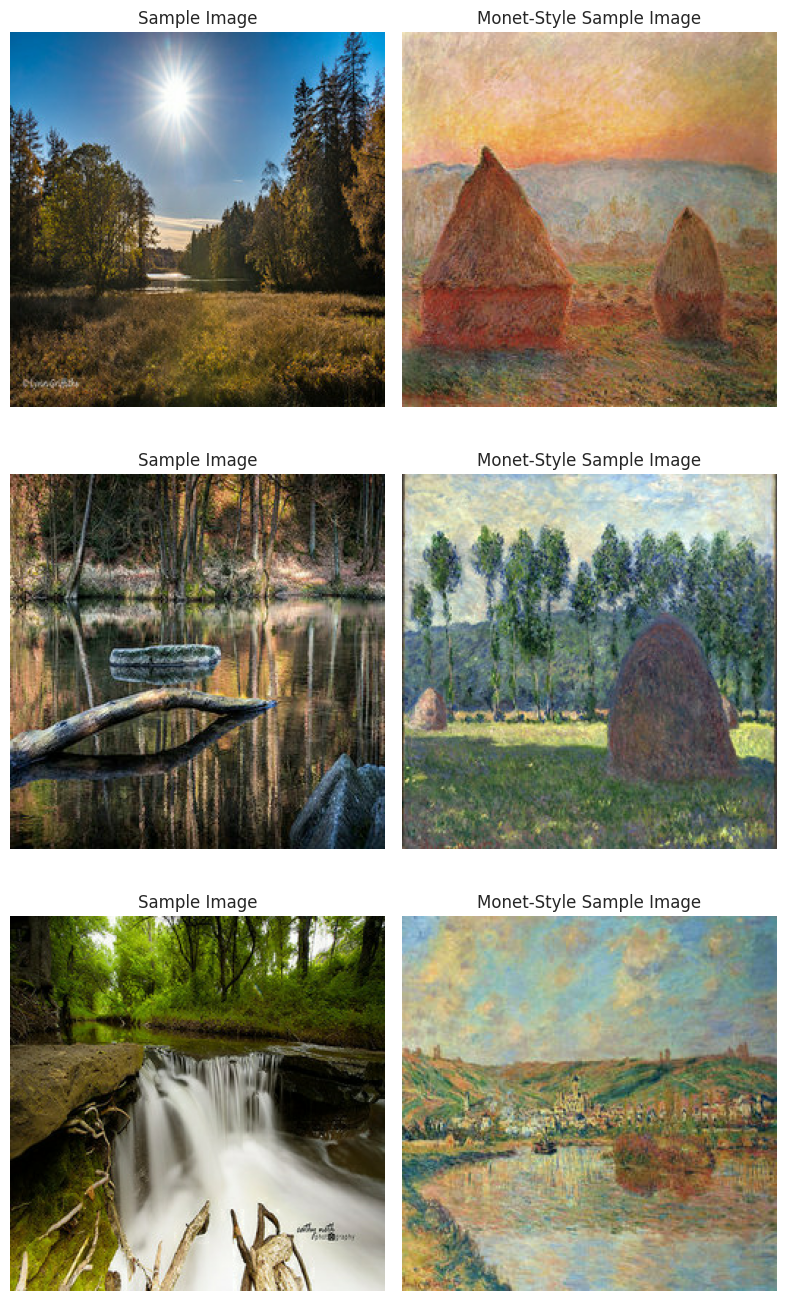

In [7]:
# Define the number of samples to take from the photo dataset
num_samples = 3

# Define the number of rows and columns for the image grid
rows = num_samples
cols = 2

# Create a new figure with subplots for each image sample
_, ax = plt.subplots(rows, cols, figsize=(8, 15))

# Loop through each sample image and plot it along with its 
#   corresponding Monet-style image
for i in range(0, num_samples):

    # Get the next sample image from the photo dataset
    sample_image = next(iter(photo_dataset))

    # Get the next corresponding Monet-style image from the monet dataset
    sample_monet = next(iter(monet_dataset))

    # Display the sample image in the first subplot, 
    #   rescaling the pixel values from [-1, 1] to [0, 1]
    ax[i, 0].set_title('Sample Image')
    ax[i, 0].imshow(sample_image[0] * 0.5 + 0.5)
    ax[i, 0].axis('off')

    # Display the corresponding Monet-style image in the second subplot, 
    #   rescaling the pixel values from [-1, 1] to [0, 1]
    ax[i, 1].set_title('Monet-Style Sample Image')    
    ax[i, 1].imshow(sample_monet[0] * 0.5 + 0.5)
    ax[i, 1].axis('off')

    # Padding between subplots and labels
    plt.tight_layout(pad=1)

## 3.2 - RGB Channels
The three color channels in an RGB image correspond to the intensity values of red, green, and blue light, respectively. By plotting each channel separately, we can see how much each channel contributes to the overall color of the image and identify any color biases or imbalances in the image. 

Separate RGB channel plots can also be useful for image processing tasks such as color correction, contrast adjustment, and image segmentation. By adjusting the intensity values of each channel separately, we can change the overall color balance, enhance specific colors or details, or separate different objects or regions in the image based on their color characteristics.

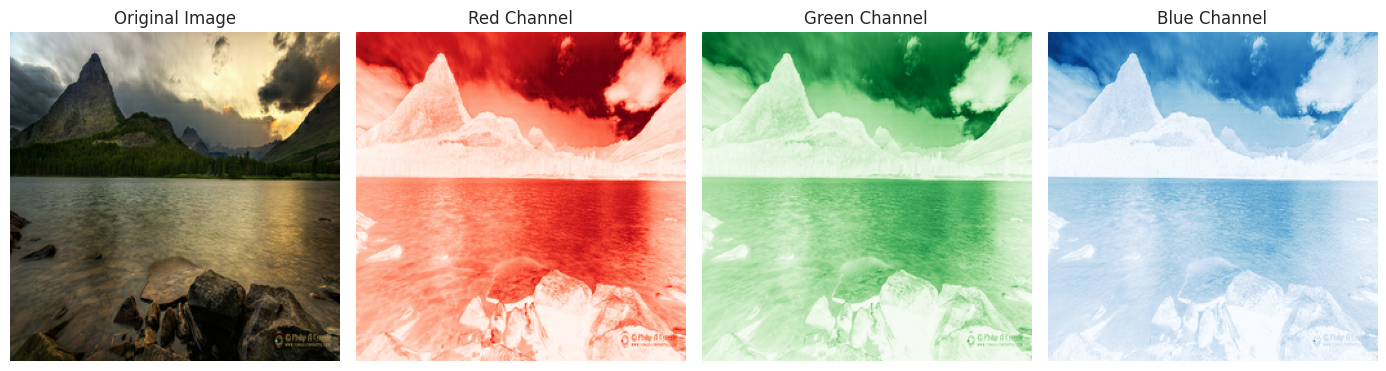

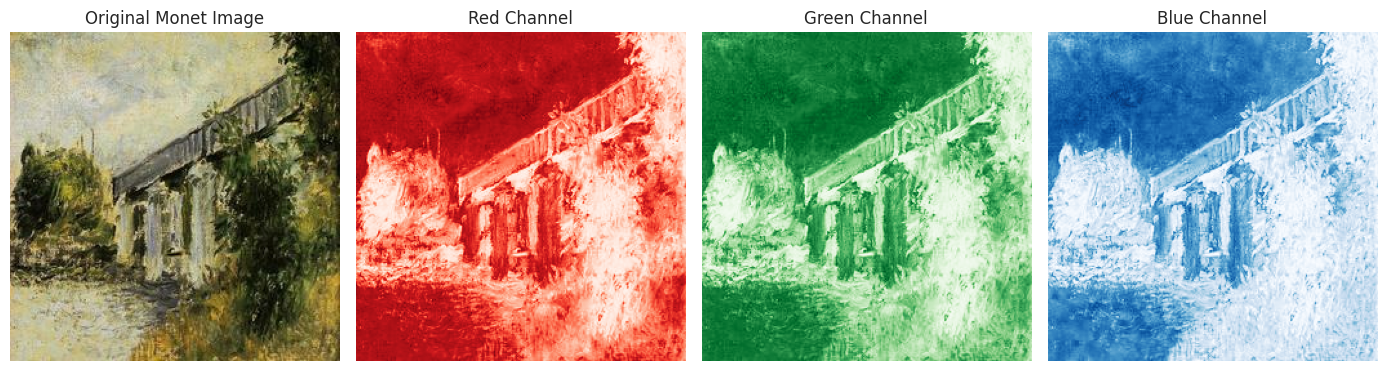

In [8]:
def plot_rgb_channels(dataset, type):

    # Get size of sample dataset
    n_samples = photo_dataset.take(samples).reduce(
        0, lambda x, _: x + 1).numpy()

    # Iterate through the sample images
    for i in range(0, n_samples):

        # Normalize the image and split into its color channels
        image = next(iter(dataset))[0] * 0.5 + 0.5
        red_channel, green_channel, blue_channel = \
            tf.split(image, num_or_size_splits=3, axis=2)

        # Create subplots for each image and its channels
        fig, axs = plt.subplots(1, 4, figsize=(14, 4))

        # Original
        axs[0].imshow(image)
        axs[0].set_title('Original ' + type)
        axs[0].axis('off')

        # Red channel
        axs[1].imshow(red_channel[:, :, 0], cmap='Reds')
        axs[1].set_title('Red Channel')
        axs[1].axis('off')

        # Green channel
        axs[2].imshow(green_channel[:, :, 0], cmap='Greens')
        axs[2].set_title('Green Channel')
        axs[2].axis('off')

        # Blue channel
        axs[3].imshow(blue_channel[:, :, 0], cmap='Blues')
        axs[3].set_title('Blue Channel')
        axs[3].axis('off')

        # Padding between subplots and labels
        plt.tight_layout(pad=1)
        None

# Define samples
samples = 1

# Plot images + RGB channels
plot_rgb_channels(photo_dataset.take(samples), 'Image')
plot_rgb_channels(monet_dataset.take(samples), 'Monet Image')


## 3.3 - RGB Histogram 
The purpose of an RGB histogram per channel is to visualize the distribution of pixel intensities in each color channel (red, green, and blue) of an RGB image. An RGB histogram is a graph that shows the frequency of occurrence of each pixel intensity value in the image.

The RGB histogram per channel can be helpful for various image processing tasks, such as color correction, image enhancement, and segmentation. For instance, we can adjust the color balance of an image by equalizing the histograms of its three color channels or by applying different color filters to each channel.

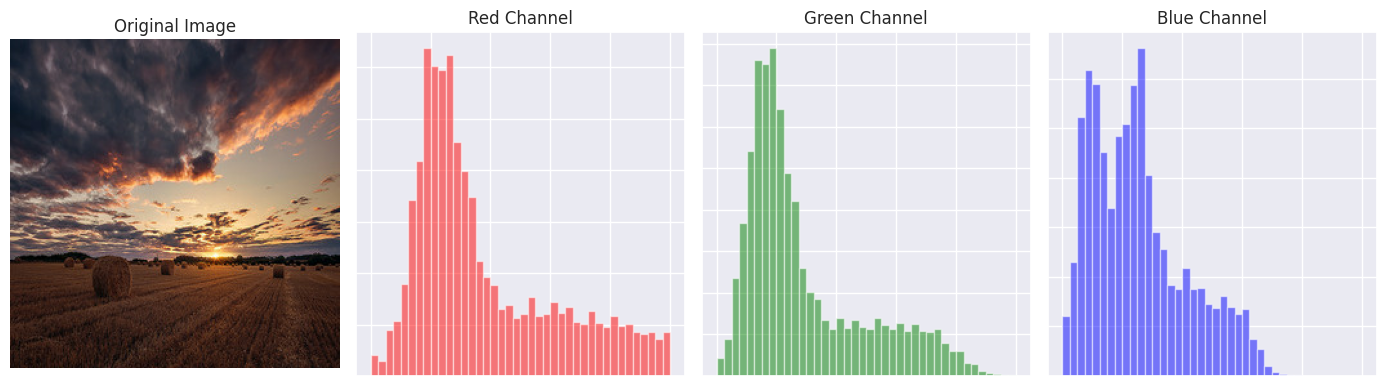

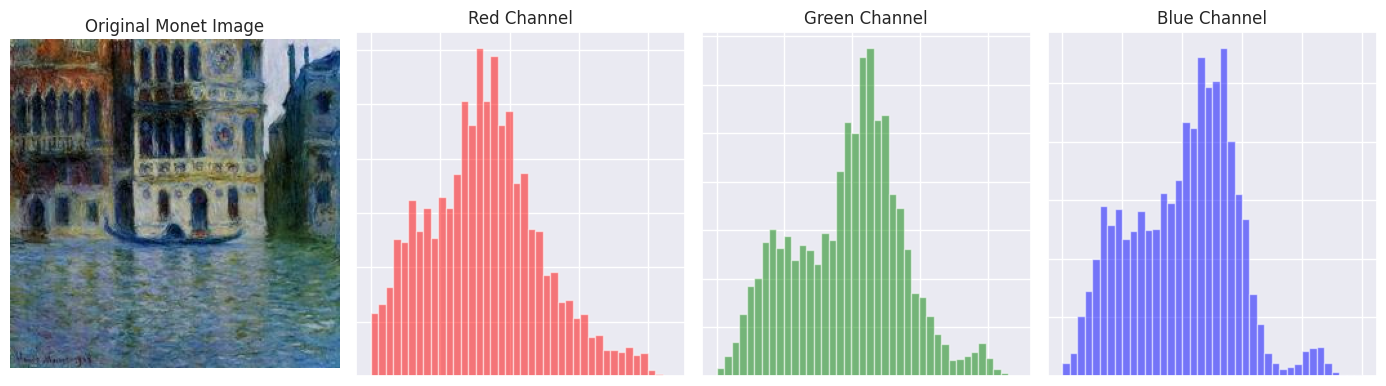

In [9]:
def plot_rgb_histogram(dataset, type):

    # Get size of sample dataset
    n_samples = photo_dataset.take(samples).reduce(
        0, lambda x, _: x + 1).numpy()

    # Iterate through the sample images
    for i in range(0, n_samples):

        # Normalize the image and split into its color channels
        image = next(iter(dataset))[0] * 0.5 + 0.5
        red_channel, green_channel, blue_channel = \
            tf.split(image, num_or_size_splits=3, axis=2)

        # Flatten the channels and concatenate them into a single vector
        red_values = tf.reshape(red_channel, [-1]).numpy()
        green_values = tf.reshape(green_channel, [-1]).numpy()
        blue_values = tf.reshape(blue_channel, [-1]).numpy()

        # Create subplots for each image and its channels
        fig, axs = plt.subplots(1, 4, figsize=(14, 4))

        # Set Seaborn style
        sns.set(style='darkgrid')        

        # Original image
        axs[0].imshow(image)
        axs[0].set_title('Original ' + type)
        axs[0].axis('off')        

        # Red channel
        axs[1].hist(red_values, bins=40, alpha=0.5, color='red', 
                    density=True)
        axs[1].set_title('Red Channel')
        axs[1].set_xticklabels([])
        axs[1].set_yticklabels([])

        # Green channel
        axs[2].hist(green_values, bins=40, alpha=0.5, color='green', 
                    density=True)
        axs[2].set_title('Green Channel')
        axs[2].set_xticklabels([])
        axs[2].set_yticklabels([])

        # Blue channel
        axs[3].hist(blue_values, bins=40, alpha=0.5, color='blue', 
                    density=True)
        axs[3].set_title('Blue Channel')        
        axs[3].set_xticklabels([])
        axs[3].set_yticklabels([])

        # Padding between subplots and labels
        plt.tight_layout(pad=1)
        None

# Define samples
samples = 1

# Plot images + RGB channels

plot_rgb_histogram(photo_dataset.take(samples), 'Image')
plot_rgb_histogram(monet_dataset.take(samples), 'Monet Image')


## 3.4 - RGB Kernel Density Estimation - KDE
To help visualizing the joint distribution of three variables, I'm plotting an RGB KDE plot, which is a type of visualization that combines kernel density estimation (KDE) with a color map to represent the density of three-dimensional data. In an RGB KDE plot, each data point is represented as a three-dimensional point in the RGB color space, where the three color channels (red, green, and blue) correspond to the values of three variables.

The RGB KDE plots are useful for visualizing the joint distribution of three variables, especially when the data is high-dimensional and difficult to visualize using traditional plots such as scatter plots or histograms. They can also reveal patterns and structures in the data that might not be apparent from lower-dimensional projections.

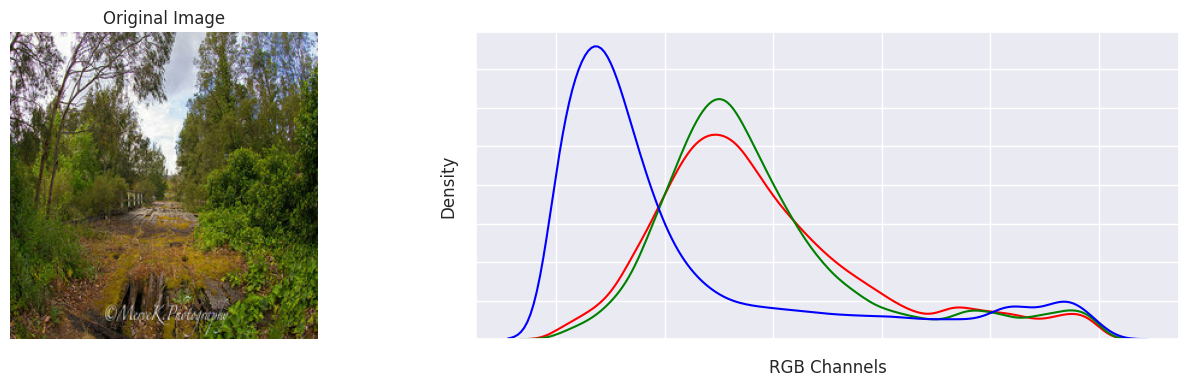

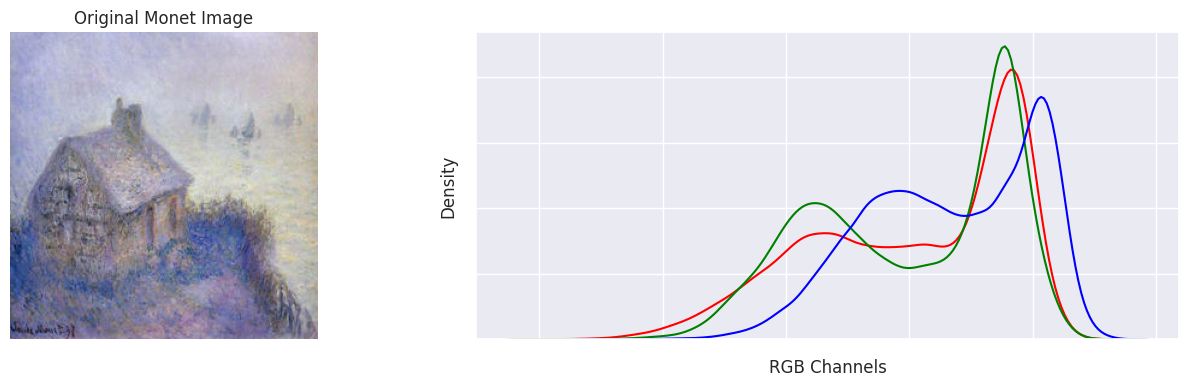

In [10]:
def plot_rgb_histogram(dataset, type):

    # Get size of sample dataset
    n_samples = photo_dataset.take(samples).reduce(
        0, lambda x, _: x + 1).numpy()

    # Iterate through the sample images
    for i in range(0, n_samples):

        # Normalize the image and split into its color channels
        image = next(iter(dataset))[0] * 0.5 + 0.5
        red_channel, green_channel, blue_channel = \
            tf.split(image, num_or_size_splits=3, axis=2)

        # Flatten the channels and concatenate them into a single vector
        red_values = tf.reshape(red_channel, [-1]).numpy()
        green_values = tf.reshape(green_channel, [-1]).numpy()
        blue_values = tf.reshape(blue_channel, [-1]).numpy()

        # Create subplots for each image and its channels
        fig, axs = plt.subplots(1, 2, figsize=(14, 4))

        # Set Seaborn style
        sns.set(style='darkgrid')        

        # Original image
        axs[0].imshow(image)
        axs[0].set_title('Original ' + type)
        axs[0].axis('off')        

        # Green channel
        sns.kdeplot(red_values, color='red', ax=axs[1])
        sns.kdeplot(green_values, color='green', ax=axs[1])
        sns.kdeplot(blue_values, color='blue', ax=axs[1])
        axs[1].set_xticklabels([])
        axs[1].set_yticklabels([])
        axs[1].set_xlabel('RGB Channels')
        axs[1].set_ylabel('Density')

        # Padding between subplots and labels
        plt.tight_layout(pad=1)
        None

# Define samples
samples = 1

# Plot images + RGB channels

plot_rgb_histogram(photo_dataset.take(samples), 'Image')
plot_rgb_histogram(monet_dataset.take(samples), 'Monet Image')


## 4 - Model Architecture

Building upon the basic CycleGAN architecture outlined in Amy Jang's tutorial, I plan to enhance the model with my own improvements. The general approach is based on the UNet architecture.

* The UNet architecture is a type of fully convolutional neural network that was designed for semantic segmentation tasks. It was introduced by Olaf Ronneberger et al. in 2015 and has since been widely used in various image segmentation tasks.

* The UNet architecture consists of an encoder path and a corresponding decoder path, with a bottleneck layer in between. The encoder path consists of a series of convolutional layers that are used to extract features from the input image. The decoder path consists of a series of up-sampling layers that are used to reconstruct the original image from the extracted features.

* The encoder path starts with a series of convolutional layers that downsample the input image, with each layer reducing the spatial dimensions of the feature maps while increasing the number of channels. This allows the network to learn increasingly complex representations of the input image at multiple scales. The downsampling is typically done using max pooling or strided convolutional layers.

* The bottleneck layer in the middle of the network is usually a deep convolutional layer that serves as a bridge between the encoder and decoder paths. This layer captures the most abstract and compressed representation of the input image.

* The decoder path is the reverse of the encoder path, with each layer consisting of an up-sampling operation that increases the spatial dimensions of the feature maps while reducing the number of channels. The up-sampling is typically done using transpose convolutional layers. The up-sampling layers are often concatenated with the corresponding feature maps from the encoder path, allowing the network to leverage both low-level and high-level features to produce a segmentation map.

* Finally, a 1x1 convolutional layer is used to reduce the number of channels to the desired number of output classes, and a softmax activation function is applied to obtain a probability distribution over the output classes.

The UNet architecture is popular for its ability to produce highly accurate segmentations even with limited amounts of training data. Its design allows it to leverage both low-level and high-level features, which is particularly useful for tasks where fine details and context are important.

Additional details here: https://en.wikipedia.org/wiki/U-Net

### 4.1 - Downsampling Block

The downsample function takes in several arguments to specify the architecture of the downsampling block. It creates a Sequential model to hold the layers of the block and returns it as the output.

* The function starts by initializing the parameters for the layers using tf.random_normal_initializer for the convolutional kernel weights and keras.initializers.RandomNormal for the gamma parameter of InstanceNormalization.

* The result model is then created as a Sequential object, and a Conv2D layer is added to it with the specified number of filters, kernel size, and stride of 2. This reduces the spatial dimensions of the feature maps while increasing the number of channels.

* If apply_instancenorm is set to True (default), an instance normalization layer is added to normalize the activations of the Conv2D layer.

* A PReLU activation function is then applied to the output of the normalization layer. This is a variation of the ReLU activation function that introduces a learnable parameter that allows the function to be more flexible in its behavior.

* If apply_dropout is set to True (defalut), a dropout layer is added to the block to reduce overfitting. This randomly sets a fraction of the input units to 0 at each update during training time.

* Finally, the completed downsampling block is returned as the output of the function.

### Improvements Made to the Original Code:

* **Added a dropout layer**: Dropout layers can help reduce overfitting by randomly dropping some activations during training. In the downsample block, adding dropout can help to prevent the model from memorizing too many details from the input image, which may not be relevant for the task at hand. This can be especially important when dealing with complex datasets, where overfitting can be a significant issue.

* **Replaced LeakyReLU with PReLU**: Leaky ReLU was introduced to address limitations of ReLU by allowing a small positive slope for negative inputs, but this can result in "dead" neurons with zero activation, which can lead to some artifacts on the output image. PReLU improves upon Leaky ReLU by introducing a learnable parameter for the negative slope, allowing it to adapt to the data during training.





In [11]:
def downsample(filters, size, apply_instancenorm=True, apply_dropout=True):

    # Set up initializers for the model parameters

    # Initializer for the convolutional kernel weights
    initializer = tf.random_normal_initializer(0., 0.02) 
    # Initializer for the gamma parameter of InstanceNormalization
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02) 

    # Create a Sequential model to hold the layers of the downsampling block
    result = keras.Sequential()

    # Add a convolutional layer with specified number of filters, 
    #   kernel size, and stride of 2 (to downsample)
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    # Add an instance normalization layer to normalize the activations
    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(
            gamma_initializer=gamma_init))

    # Use PReLU activation instead of the traditional ReLU
    result.add(layers.PReLU())

    # Add a dropout layer to reduce overfitting
    if apply_dropout:
        result.add(layers.Dropout(0.5))

    # Return the completed downsampling block
    return result

### 4.2 - Upsampling Block

The Upsampling Block function takes in three arguments:

* filters: the number of filters to use in the convolutional layer
size: the size of the kernel to use in the convolutional layer
apply_dropout: a Boolean value indicating whether or not to include a dropout layer in the block. This is set to True by default.

* The function initializes the weights of the convolutional layer using a normal distribution with mean 0 and standard deviation 0.02, and initializes the gamma parameter of the instance normalization layer with a random normal distribution with mean 0 and standard deviation 0.02.

* The function adds a transposed convolutional layer to result with the specified filters, size, and strides=2 (which doubles the input resolution in both dimensions). The padding is set to 'same', which pads the input such that the output has the same dimensions as the input.

* The function adds an instance normalization layer to result with the gamma parameter initialized as described above. Instance normalization normalizes the output of each filter across spatial dimensions (i.e., across rows and columns).

* If apply_dropout is True, the function adds a dropout layer to result with a rate of 0.5, which means that each neuron in the layer has a 50% chance of being randomly set to 0 during training to reduce overfitting.

* The function adds a parametric rectified linear unit (PReLU) activation function to result. PReLU is a variant of the rectified linear unit (ReLU) activation function that introduces a small negative slope for negative input values. This can help prevent "dead" neurons (i.e., neurons that output 0 for all inputs).

* The function returns the result model, which represents the complete upsampling block.

### Improvements Made to the Original Code:

* **Added a dropout layer**: 
Adding a dropout layer in the upsampling block can help prevent overfitting of the model by randomly dropping out a fraction of the activations in the layer. This can be particularly helpful when the model has many parameters and may have a tendency to memorize the training data rather than learning to generalize to new data. By randomly dropping out some activations during training, the model is forced to learn more robust features that are less sensitive to noise and small variations in the input data.

* **Replaced LeakyReLU with PReLU**: Replacing LeakyReLU with PReLU in the upsampling block can be useful because PReLU can learn negative slope values that are optimized during training, whereas LeakyReLU always has a fixed negative slope value. This allows PReLU to potentially learn more complex and diverse activation patterns that may be better suited to the characteristics of the data being used. Additionally, PReLU has been shown to be effective in preventing the saturation of gradients in deep networks, which can help improve the training process and lead to better performance.

In [12]:
def upsample(filters, size, apply_dropout=True):

    # Initialize random weight values and gamma parameter
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    # Define the sequential model
    result = keras.Sequential()
    
    # Add a transposed convolutional layer
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))
    
    # Add instance normalization layer
    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    # Add dropout layer for regularization
    if apply_dropout:
        result.add(layers.Dropout(0.5))

    # Add a parametric ReLU activation function
    result.add(layers.PReLU())    

    return result


## 4.3 Generator

The code defines a generator for a CycleGAN architecture that can be used for image-to-image translation tasks. The generator takes an input image of shape (256, 256, 3) and outputs a generated image of the same shape. The generator architecture is composed of two parts, a down-sampling path and an up-sampling path.

* The down-sampling path consists of several down-sampling blocks, where each block applies a convolutional layer followed by instance normalization, a PReLU activation function, and optionally a dropout layer. The number of filters is increased from 64 to 512 as the spatial resolution is halved in each block. The down-sampling path ends with a convolutional block that applies no normalization or activation.

* The up-sampling path consists of several up-sampling blocks, where each block applies a transposed convolutional layer followed by instance normalization, a PReLU activation function, and optionally a dropout layer. The number of filters is decreased from 512 to 64 as the spatial resolution is doubled in each block. The up-sampling path ends with a transposed convolutional block that applies no normalization or activation.

* Skip connections are established between the down-sampling path and the up-sampling path by concatenating the output of each down-sampling block with the output of the corresponding up-sampling block. The final output is obtained by applying a convolutional layer with a tanh activation function that maps the output to the range [-1, 1]. The final layer applies no normalization or activation.

### Improvements Made to the Original Code:

* **Use instance normalization instead of batch normalization**: Instance normalization is typically used in style transfer tasks, and can produce better results than batch normalization.





In [13]:
def Generator():
    
    # Input layer
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])

    # Downstack - downsampling layers
    down_stack = [
        downsample(64, 4, apply_instancenorm=True), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    # Upstack - upsampling layers
    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    # Define initializer
    initializer = tf.random_normal_initializer(0., 0.02)

    # Define final layer with Tanh activation
    last = tf.keras.layers.Conv2DTranspose(3, 4,   # (bs, 256, 256, 3)
                                           strides=2,
                                           padding='same',
                                           kernel_initializer=initializer,
                                           activation='tanh') 

    # Apply downsampling layers
    x = inputs

    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Apply upsampling layers and establish skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    # Apply final layer
    x = last(x)    

    return tf.keras.Model(inputs=inputs, outputs=x)


### 4.4 - Discriminator

This code defines the discriminator model for the GAN model. The discriminator takes in an input image of size 256x256 with 3 color channels. 

* The input image is passed through several downsampling layers that decrease the spatial resolution of the image while increasing the number of channels. Each downsampling layer performs a convolution operation with a kernel size of 4 and a stride of 2, followed by an instance normalization layer and a LeakyReLU activation function.

* After the downsampling layers, a convolutional layer with a kernel size of 4 and a stride of 1 is applied to the output of the last downsampling layer, followed by instance normalization and a LeakyReLU activation function. A zero-padding layer is applied before and after this layer to ensure that the output size matches that of the previous layer.

* Finally, a convolutional layer with a kernel size of 4 and a stride of 1 is applied to the output of the previous layer to produce a single-channel output representing the discriminator's confidence that the input image is real. The output of the discriminator is a tensor of size (batch_size, 14, 14, 1).

### Improvements Made to the Original Code:

* **Increased the depth of the network**: Since the images are 256x256x3, by having more layers, the discriminator is able to learn more complex and discriminative features, allowing it to better distinguish between real and fake images. 

In [14]:
def Discriminator():

    # Define initializers for weights and biases
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    # Define input layer with shape (256, 256, 3)
    inp = layers.Input(shape=[256, 256, 3], name='input_image')
    x = inp    

    # Apply downsampling layers with decreasing number of filters
    down1 = downsample(64, 4, False)(inp) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)
    down4 = downsample(512, 4)(down3) # (bs, 16, 16, 512)

    # Zero padding to increase spatial dimension
    zero_pad1 = layers.ZeroPadding2D()(down4) # (bs, 18, 18, 512)

    # Convolutional layer with 1024 filters and kernel size of 4x4
    conv1 = layers.Conv2D(1024, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 15, 15, 1024)

    # Instance normalization
    norm1 = tfa.layers.InstanceNormalization(
        gamma_initializer=gamma_init)(conv1)

    # LeakyReLU activation function
    leaky_relu1 = layers.LeakyReLU()(norm1)

    # Zero padding to increase spatial dimension
    zero_pad2 = layers.ZeroPadding2D()(leaky_relu1) # (bs, 17, 17, 1024)

    # Convolutional layer with 1 filter and kernel size of 4x4
    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(
                             zero_pad2) # (bs, 14, 14, 1)

    # Define and return the model
    return tf.keras.Model(inputs=inp, outputs=last)


### 4.5 - Implement Generator/Discriminator Instances

This code defines four deep neural network models for a CycleGAN implementation, with each generator and discriminator having their own instance. This is the basic setup for the cycleGAN model, which uses two generators and two discriminators in a cycle-consistent adversarial training framework to learn to translate between two different domains of images.

* The Generator model monet_generator is used to transform photos into Monet-style paintings, while the photo_generator model is used to transform Monet paintings to be more like photos. The Discriminator model monet_discriminator is used to differentiate real Monet paintings and generated Monet paintings, while photo_discriminator is used to differentiate real photos and generated photos.

In [15]:
%%time

with strategy.scope():
    # Transforms photos to Monet-style paintings
    monet_generator = Generator() 
    # Transforms Monet paintings to be more like photos
    photo_generator = Generator() 
    
    # Differentiates real Monet paintings and generated Monet paintings
    monet_discriminator = Discriminator() 
    # Differentiates real photos and generated photos
    photo_discriminator = Discriminator() 

CPU times: user 8.25 s, sys: 653 ms, total: 8.9 s
Wall time: 15 s



### 4.6 - CycleGAN Model

This is the `CycleGan` class implementation in TensorFlow 2.x for a CycleGAN model. In the code, there are two generators and two discriminators. The two generators are monet_generator and photo_generator, which are responsible for transforming input images from one domain to another.

* The monet_generator takes in real photos and transforms them to Monet-style paintings, while the photo_generator takes in real Monet paintings and transforms them to be more like photos. These generators are used during training to generate fake images that will be used to train the discriminators.

* On the other hand, the two discriminators are monet_discriminator and photo_discriminator, which are responsible for differentiating between real and fake images. The monet_discriminator is trained to distinguish between real Monet-style paintings and fake Monet-style paintings generated by the monet_generator, while the photo_discriminator is trained to distinguish between real photos and fake photos generated by the photo_generator.

* During training, the discriminators are used to calculate the discriminator loss, which measures how well they are able to differentiate between real and fake images. The generators are then trained to minimize the generator loss, which measures how well they are able to fool the discriminators into thinking that their generated images are real.

* The code uses tf.GradientTape() to record the operations performed on the tensors in the forward pass, which can then be used to compute gradients in the backward pass using the tape.gradient() method. The generator loss is calculated using the discriminator output on the fake images, while the discriminator loss is calculated using the discriminator outputs on both real and fake images.

* In the train_step() method, the losses for the generators and discriminators are computed. The generator losses are computed based on the discriminator's output for the fake images. The cycle consistency losses measure the difference between the original images and the reconstructed images for both domains. The same-style losses measure the difference between the original images and the same-style images for both domains. The total generator loss is the sum of the generator losses, scaled by the hyperparameter lambda_cycle and lambda_same_style, and the cycle consistency and same-style losses. The discriminator losses are computed based on the discriminator's output for both real and fake images for both domains.

* The cycle consistency loss ensures that the output of a generator followed by the inverse generator is close to the original input. The identity loss ensures that the generator is able to preserve the input image to some extent, and is useful in preventing the generators from collapsing to a single point in the output space.

In [16]:
class CycleGan(keras.Model):
    def __init__(
        self,
        # Transforms photos to Monet-style paintings
        monet_generator,
        # Transforms Monet paintings to be more like photos
        photo_generator,
        # Differentiates real Monet paintings and generated Monet paintings
        monet_discriminator,
        # Differentiates real photos and generated photos
        photo_discriminator,
        # Hyperparameter for controlling the weight of the cycle consistency loss
        lambda_cycle=10,
    ):
        # Constructor of the parent class
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        # Optimizer for the Monet generator
        m_gen_optimizer,
        # Optimizer for the photo generator
        p_gen_optimizer,
        # Optimizer for the Monet discriminator
        m_disc_optimizer,
        # Optimizer for the photo discriminator
        p_disc_optimizer,
        # Loss function for the generator
        gen_loss_fn,
        # Loss function for the discriminator
        disc_loss_fn,
        # Loss function for the cycle consistency term
        cycle_loss_fn,
        # Loss function for the identity term
        identity_loss_fn
    ):
        # Constructor of the parent class
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # Photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # Monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # Generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # Discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # Discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # Evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # Evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(
                real_monet, cycled_monet, self.lambda_cycle) + \
                    self.cycle_loss_fn(
                        real_photo, cycled_photo, self.lambda_cycle)

            # Evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + \
                self.identity_loss_fn(
                    real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + \
                self.identity_loss_fn(
                    real_photo, same_photo, self.lambda_cycle)

            # Evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, 
                                                disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, 
                                                disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(
            total_monet_gen_loss, self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(
            total_photo_gen_loss, self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(
            monet_disc_loss, self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(
            photo_disc_loss, self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(
            zip(monet_generator_gradients, 
                self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(
            zip(photo_generator_gradients, 
                self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(
            zip(monet_discriminator_gradients, 
                self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(
            zip(photo_discriminator_gradients, 
                self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        } 
            


### 4.7 - Discriminator Loss

The discriminator loss function takes in two inputs: real and generated. real is a tensor representing the discriminator's output for real images, and generated is a tensor representing the discriminator's output for fake/generated images.

* The loss function uses binary cross-entropy loss, which is a standard loss function for binary classification problems. The from_logits=True argument is used to indicate that the input to the loss function is not normalized between 0 and 1, but rather unbounded logits.

* The discriminator's goal is to correctly classify real images as real and generated images as generated. Therefore, the loss function computes two separate losses: one for the real images and one for the generated images. The real loss is the binary cross-entropy between the discriminator's output for real images and a tensor of ones (indicating that these are real images), while the generated loss is the binary cross-entropy between the discriminator's output for generated images and a tensor of zeros (indicating that these are generated images).

* The total loss is the sum of the real and generated losses, which measures how well the discriminator is able to distinguish between real and generated images.

In [17]:
with strategy.scope():

    def discriminator_loss(real, generated):

        # Calculate loss for real images
        real_loss = tf.keras.losses.BinaryCrossentropy(
            from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(
                tf.ones_like(real), real)

        # Calculate loss for generated (fake) images
        generated_loss = tf.keras.losses.BinaryCrossentropy(
            from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(
                tf.zeros_like(generated), generated)

        # Combine the losses
        total_disc_loss = real_loss + generated_loss

        # Multiply by 0.5 to get the average of the two losses
        return total_disc_loss * 0.5

### 4.8 - Generator Loss

The generator loss function takes in one input: generated, which is a tensor representing the discriminator's output for fake/generated images.

* Similar to the discriminator loss function, the generator loss function uses binary cross-entropy loss with from_logits=True. However, in this case, the goal of the loss function is to encourage the generator to generate images that are classified as real by the discriminator. Therefore, the loss function computes the binary cross-entropy between the discriminator's output for generated images and a tensor of ones (indicating that these are real images).

* The generator's goal is to minimize the generator loss, which encourages the generator to generate images that are more likely to be classified as real by the discriminator.

In [18]:
with strategy.scope():
            
    # Define generator loss function
    def generator_loss(generated):
        
        # Compute binary crossentropy loss between ones and generated images
        return tf.keras.losses.BinaryCrossentropy(
            from_logits=True, 
            reduction=tf.keras.losses.Reduction.NONE)(
                tf.ones_like(generated), generated)            

### 4.9 - Cycle Consistency Loss

The cycle consistency loss function takes in two inputs: real_image and cycled_image. real_image is a tensor representing the real image, and cycled_image is a tensor representing the image generated by applying the generator twice (once in each direction) to the real image.

* The loss function calculates the absolute difference between the real image and the cycled image using tf.abs, and then takes the mean of the absolute differences using tf.reduce_mean. The resulting loss is multiplied by a hyperparameter lambda_cycle, which controls the weight of the cycle consistency loss relative to the other losses in the total generator loss.

* The purpose of the cycle consistency loss is to encourage the generator to generate images that are consistent with the original image after going through the cycle of being converted to the other domain and back again. This helps to maintain the visual quality of the generated images and ensure that they remain faithful to the original image.

In [19]:
with strategy.scope():
    
    def cycle_loss(real_image, cycled_image, lambda_cycle):

        # calculate the absolute difference between the real and cycled image
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        # Multiply the loss by the lambda_cycle hyperparameter and 
        #   return the result
        return lambda_cycle * loss1

### 4.10 - Identity Loss

The identity loss function takes in two inputs: real_image and same_image. real_image is a tensor representing the real image, and same_image is a tensor representing the image generated by applying the generator to the real image without any modification.

* The loss function calculates the absolute difference between the real image and the same image using tf.abs, and then takes the mean of the absolute differences using tf.reduce_mean. The resulting loss is multiplied by a hyperparameter lambda_cycle, which controls the weight of the identity loss relative to the other losses in the total generator loss. Additionally, the loss is multiplied by 0.5, as recommended in the CycleGAN paper, to prevent the identity loss from dominating the other losses.

* The purpose of the identity loss is to encourage the generator to preserve the original content of the image when generating an image in the same domain. This is particularly important when the generator is used to convert an image from one domain to the same domain, as the goal in this case is to ensure that the generated image is visually similar to the original image.

In [20]:
with strategy.scope():

    def identity_loss(real_image, same_image, lambda_cycle):

        # Calculate the absolute difference between 
        #   the real image and the same image
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        
        # Multiply the loss by lambda_cycle and 0.5
        # Lambda_cycle controls the weight of the identity loss
        # Multiplying by 0.5 is equivalent to dividing by 2, 
        #   and is done to match the loss scale of other losses
        return lambda_cycle * 0.5 * loss


### 4.11- Optimizers

In this code block, I am defining the optimizers that will be used to update the weights of the generator and discriminator models during training. The learning rate schedule is defined using ExponentialDecay which starts with the initial_learning_rate and decays it over time according to the decay_rate and decay_steps parameters.

The Adam optimizer is used, which is an adaptive learning rate optimization algorithm that is well-suited for large datasets and high-dimensional parameter spaces. The beta_1 parameter is set to 0.5 and weight_decay to 1e-4 to prevent overfitting during training.

Separate optimizers are defined for the Monet and Photo generators and discriminators.

### Improvements Made to the Original Code:

* **Learning rate scheduling**: Learning rate scheduling can improve the performance of your model by dynamically adjusting the learning rate during training. In the early stages of training, a high learning rate can help the model quickly converge to a reasonable solution, but later in training, a lower learning rate is often needed to fine-tune the model and avoid overfitting.

* **Weight decay**: Weight decay adds a penalty term to the loss function that encourages the model to have smaller weights. This can help prevent overfitting and improve generalization. 


In [21]:
with strategy.scope():

    # Define learning rate scheduling
    initial_learning_rate = 2e-4
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate,
        decay_steps=10000,
        decay_rate=0.9)

    # Define optimizers with learning rate scheduling and weight decay
    monet_generator_optimizer = tf.keras.optimizers.Adam(
        lr_schedule, beta_1=0.5, weight_decay=1e-4)
    photo_generator_optimizer = tf.keras.optimizers.Adam(
        lr_schedule, beta_1=0.5, weight_decay=1e-4)
    monet_discriminator_optimizer = tf.keras.optimizers.Adam(
        lr_schedule, beta_1=0.5, weight_decay=1e-4)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(
        lr_schedule, beta_1=0.5, weight_decay=1e-4)


### 4.12 - Model Summary

Visualizing the CycleGAN model helps to understand how it transforms images from one domain to another. It is helpful to see how the generator learns to convert input images from one domain to another, and how the discriminator learns to distinguish between real and generated images.

### Generator

The diagram below depicts the Generator model, which is notably more intricate than the discriminator. Its complexity is unsurprising given the Generator's critical role in generating new data that resembles the training data distribution.

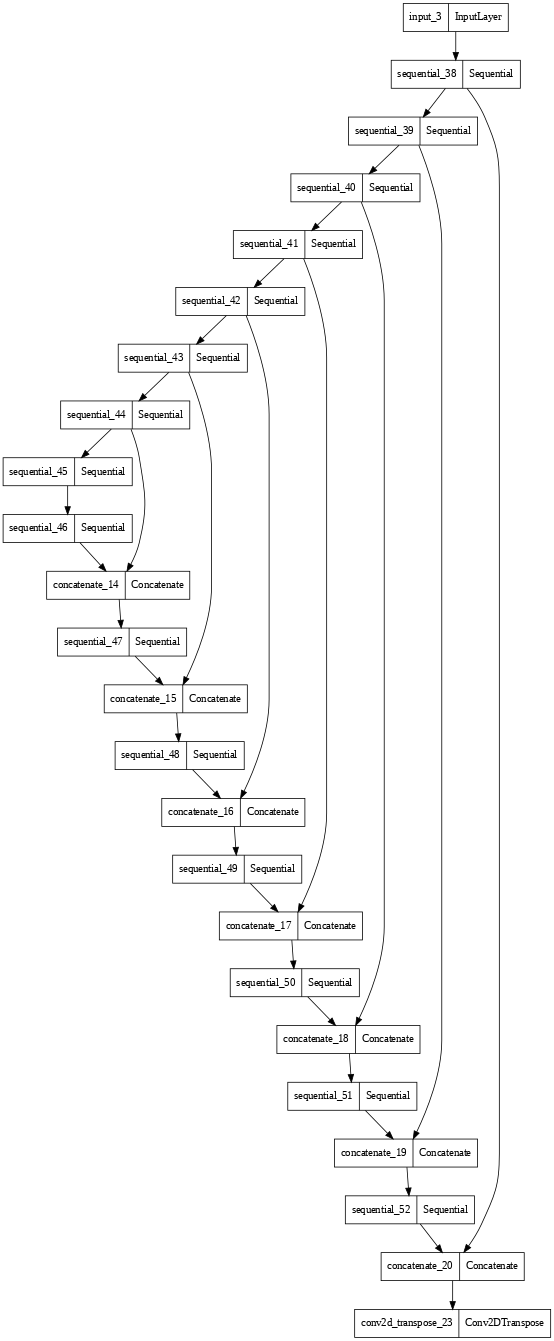

In [22]:
# Display generator
tf.keras.utils.plot_model(Generator(), dpi=56)

### Discriminator

The diagram of the discriminator model shows a significantly simpler architecture compared to that of the generator. This is because the discriminator's primary task is to classify whether a given input is real or fake, whereas the generator is responsible for generating realistic data.

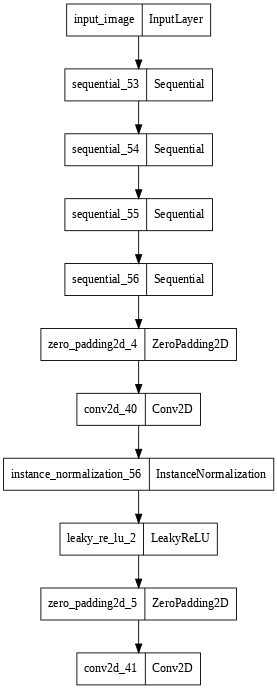

In [23]:
tf.keras.utils.plot_model(Discriminator(), dpi=64)

### 4.13 - Compile Model
This code creates an instance of the CycleGan model by calling the CycleGan constructor and passing in the four generators and discriminators that were defined earlier, along with the hyperparameter lambda_cycle which determines the weight given to the cycle loss.

Then, the model is compiled using the Adam optimizer with the four specified optimizers for each generator and discriminator. The generator and discriminator loss functions are also passed in, as well as the cycle and identity loss functions.

In [24]:
with strategy.scope():

    # Create an instance of the CycleGan model
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, 
        monet_discriminator, photo_discriminator, 
        lambda_cycle=10
    )

    # Compile model
    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = cycle_loss,
        identity_loss_fn = identity_loss,
    )    

### 4.14 - Train Model

I can now finally train the model. I'm using the following parameters:

* The x parameter is set to a zipped dataset containing the Monet and photo datasets. The epochs parameter specifies the number of times the training dataset will be iterated over.

* The batch_size parameter is set to 128, which means that 128 pairs of images from the Monet and photo datasets will be fed to the model at each iteration.

* The verbose parameter is set to 1, which means that progress updates will be printed during training.

* The training progress and metrics are stored in model_history.

In [25]:
%%time

# Number of Epochs
epochs = 40

# Train model
model_history = cycle_gan_model.fit(
    x=tf.data.Dataset.zip((monet_dataset, photo_dataset)),
    epochs=epochs,
    batch_size=128,
    verbose=1
)

Epoch 1/40
300/300 [==============================] - 249s 222ms/step - monet_gen_loss: 9.2015 - photo_gen_loss: 9.3450 - monet_disc_loss: 0.4100 - photo_disc_loss: 0.4147
Epoch 2/40
300/300 [==============================] - 68s 221ms/step - monet_gen_loss: 7.9296 - photo_gen_loss: 7.8389 - monet_disc_loss: 0.5198 - photo_disc_loss: 0.5935
Epoch 3/40
300/300 [==============================] - 68s 221ms/step - monet_gen_loss: 7.1350 - photo_gen_loss: 7.7188 - monet_disc_loss: 0.6198 - photo_disc_loss: 0.4772
Epoch 4/40
300/300 [==============================] - 68s 220ms/step - monet_gen_loss: 7.5360 - photo_gen_loss: 7.4325 - monet_disc_loss: 0.5859 - photo_disc_loss: 0.6434
Epoch 5/40
300/300 [==============================] - 68s 220ms/step - monet_gen_loss: 7.6763 - photo_gen_loss: 8.2714 - monet_disc_loss: 0.5645 - photo_disc_loss: 0.3742
Epoch 6/40
300/300 [==============================] - 68s 220ms/step - monet_gen_loss: 7.5062 - photo_gen_loss: 7.4306 - monet_disc_loss: 0.4649

## 5 - Results and Analysis

Based on the results of my CycleGAN project aimed at converting photos to monet-style images, I can say that I am reasonably satisfied with the outcomes. The generated images produced by the model were visually acceptable, and the overall quality was reasonably decent.

Throughout the training process, I observed that the generator loss fluctuated, but it was generally medium to low, indicating that the model was learning to generate quality images while minimizing the error. On the other hand, the discriminator loss was consistently low, demonstrating that the discriminator was efficiently distinguishing between real and fake images.

My model achieved a **MiFID score of 59.99143**, placing me in the median of all participants. While there is always room for improvement, I am pleased with my model's performance and believe that it has the potential to generate monet-style images with high visual fidelity.

Iterating new models and testing fresh ideas proved to be one of the most significant challenges of this project. Despite the use of TPU, which was not always accessible, training the model and generating results required a considerable amount of time, which hindered our ability to make large-scale improvements. As a result, we had to carefully balance the need to test new ideas with the time and resource constraints of the project. With more resources and time available, I'm confident that I could achieve better results.


In [26]:
# Create Pandas dataframe with metrics from training
chart_df = pd.DataFrame(
    np.array(model_history.history['monet_gen_loss'])
        .reshape(epochs, -1).mean(axis=1),
    columns=['monet_gen_loss']
    )
chart_df.insert(loc=1, column='photo_gen_loss', value=np.array(
    model_history.history['photo_gen_loss']).reshape(epochs, -1).mean(axis=1))
chart_df.insert(loc=2, column='monet_disc_loss', value=np.array(
    model_history.history['monet_disc_loss']).reshape(epochs, -1).mean(axis=1))
chart_df.insert(loc=3, column='photo_disc_loss', value=np.array(
    model_history.history['photo_disc_loss']).reshape(epochs, -1).mean(axis=1))

chart_df.insert(loc=0, column='epoch', value=np.arange(1, len(chart_df) + 1))
chart_df.insert(loc=0, column='model', value='CycleGAN Model')

chart_df

model  epoch  monet_gen_loss  photo_gen_loss  monet_disc_loss  \
0   CycleGAN Model      1        7.469028        7.604221         0.085356   
1   CycleGAN Model      2        7.772466        7.431589         0.719015   
2   CycleGAN Model      3        5.363212        4.706193         0.521247   
3   CycleGAN Model      4        4.224406        4.520664         0.974976   
4   CycleGAN Model      5        6.056644        7.127635         0.814535   
5   CycleGAN Model      6        7.642010        7.013619         0.172125   
6   CycleGAN Model      7        7.888368        7.460122         0.389710   
7   CycleGAN Model      8        6.969547        5.922021         1.145291   
8   CycleGAN Model      9        8.008395        8.018525         0.082443   
9   CycleGAN Model     10        6.813774        7.554110         0.155559   
10  CycleGAN Model     11       10.665718       11.231298         0.133833   
11  CycleGAN Model     12        8.403292        7.747855         0.156445   
12  CycleGAN Model     13        7.994472        9.029095         0.358901   
13  CycleGAN Model     14        7.034662        9.017841         0.587125   
14  CycleGAN Model     15        7.519275        8.836284         0.518230   
15  CycleGAN Model     16        5.930601        5.893740         0.178547   
16  CycleGAN Model     17        7.901244        7.889316         0.057161   
17  CycleGAN Model     18        7.056610        7.096526         0.237254   
18  CycleGAN Model     19        8.839819        8.339003         0.515362   
19  CycleGAN Model     20        9.187132       10.360495         0.060395   
20  CycleGAN Model     21        7.726984        7.794689         0.140610   
21  CycleGAN Model     22        7.255168        8.685354         1.011449   
22  CycleGAN Model     23        5.649813        5.765793         0.225674   
23  CycleGAN Model     24        4.239233        6.287836         1.404089   
24  CycleGAN Model     25        6.028469        6.228994         0.224379   
25  CycleGAN Model     26        6.962841        6.818813         0.123266   
26  CycleGAN Model     27        4.817206        7.132975         0.415902   
27  CycleGAN Model     28        5.142886        4.931634         0.226668   
28  CycleGAN Model     29        7.112628        6.656783         0.323309   
29  CycleGAN Model     30        7.464166        6.771705         0.455078   
30  CycleGAN Model     31        5.253140        5.125082         0.333304   
31  CycleGAN Model     32        5.467695        5.830976         0.204773   
32  CycleGAN Model     33        6.288442        6.256167         0.613153   
33  CycleGAN Model     34        6.049683        6.071005         0.888624   
34  CycleGAN Model     35        5.582251        5.699699         0.238007   
35  CycleGAN Model     36        5.446706        6.589672         0.309188   
36  CycleGAN Model     37        5.967478        8.311589         0.768736   
37  CycleGAN Model     38        5.900470        5.341955         0.406982   
38  CycleGAN Model     39        5.911547        5.865992         0.642026   
39  CycleGAN Model     40        5.775894        6.617887         0.471161   

    photo_disc_loss  
0          0.268993  
1          1.989429  
2          0.758919  
3          0.451364  
4          0.107908  
5          0.392714  
6          0.382451  
7          0.238653  
8          0.114565  
9          0.215571  
10         0.044547  
11         0.312171  
12         0.137888  
13         0.074502  
14         0.178386  
15         0.161741  
16         0.068746  
17         1.234605  
18         0.179673  
19         0.066006  
20         0.152362  
21         0.159441  
22         0.222978  
23         0.364251  
24         0.356525  
25         0.176882  
26         0.259537  
27         0.330760  
28         0.156163  
29         0.200324  
30         0.258913  
31         1.003606  
32         0.162563  
33         0.225423  
34         0.322322  
35         0.100923  


### 5.1 - Troubleshooting Steps

Working with Tensorflow and Keras was a challenging experience, as these libraries are not the most intuitive, and error messages can be cryptic and challenging to decipher.

While there is a vast amount of information available online, the documentation was not always helpful, and most of the available resources were geared towards experienced users. As a result, resolving issues and errors became a laborious and frustrating trial-and-error process.

Despite these challenges, I persevered and was eventually able to overcome many of the obstacles and achieve what I consider a successful outcome. However, it is clear that more user-friendly documentation and clearer error messages would be beneficial in making these libraries more accessible to users with varying levels of experience.

### 5.2 - Hyperparameter Optimization Procedure

Below is a summary of the optimization procedure that I undertook in this project:

### Downsampling Block:

* **Added a dropout layer**: Dropout layers can help reduce overfitting by randomly dropping some activations during training. In the downsample block, adding dropout can help to prevent the model from memorizing too many details from the input image, which may not be relevant for the task at hand. This can be especially important when dealing with complex datasets, where overfitting can be a significant issue.

* **Replaced LeakyReLU with PReLU**: Leaky ReLU was introduced to address limitations of ReLU by allowing a small positive slope for negative inputs, but this can result in "dead" neurons with zero activation, which can lead to some artifacts on the output image. PReLU improves upon Leaky ReLU by introducing a learnable parameter for the negative slope, allowing it to adapt to the data during training.

### Upsampling Block

* **Added a dropout layer**: 
Adding a dropout layer in the upsampling block can help prevent overfitting of the model by randomly dropping out a fraction of the activations in the layer. This can be particularly helpful when the model has many parameters and may have a tendency to memorize the training data rather than learning to generalize to new data. By randomly dropping out some activations during training, the model is forced to learn more robust features that are less sensitive to noise and small variations in the input data.

* **Replaced LeakyReLU with PReLU**: Replacing LeakyReLU with PReLU in the upsampling block can be useful because PReLU can learn negative slope values that are optimized during training, whereas LeakyReLU always has a fixed negative slope value. This allows PReLU to potentially learn more complex and diverse activation patterns that may be better suited to the characteristics of the data being used. Additionally, PReLU has been shown to be effective in preventing the saturation of gradients in deep networks, which can help improve the training process and lead to better performance.

### Generator

* **Use instance normalization instead of batch normalization**: Instance normalization is typically used in style transfer tasks, and can produce better results than batch normalization.

### Discriminator

* **Increased the depth of the network**: Since the images are 256x256x3, by having more layers, the discriminator is able to learn more complex and discriminative features, allowing it to better distinguish between real and fake images. 

### Optimizers

* **Learning rate scheduling**: Learning rate scheduling can improve the performance of your model by dynamically adjusting the learning rate during training. In the early stages of training, a high learning rate can help the model quickly converge to a reasonable solution, but later in training, a lower learning rate is often needed to fine-tune the model and avoid overfitting.

* **Weight decay**: Weight decay adds a penalty term to the loss function that encourages the model to have smaller weights. This can help prevent overfitting and improve generalization. 

### Helper Functions

This section contains a collection of functions that will be used for various common tasks, such as plotting and reporting. These functions are designed to simplify the coding process.

In [27]:
"""
Plot metric charts for a given model
Inputs:
    chart_df: Pandas dataframe with metrics computed during training
    plot_val: boolean to indicate whether to plot validation results
Outputs:
    None
"""
def plot_results(chart_df, plot_val=False):
    
    # Initialize figure
    fig, axs = plt.subplots(2, 2, figsize=(12, 6))

    # Set Seaborn style
    sns.set(style='darkgrid')

    # Create lineplots
    axs[0, 0] = sns.lineplot(data=chart_df, x='epoch', y='monet_gen_loss', ax=axs[0, 0])
    axs[0, 1] = sns.lineplot(data=chart_df, x='epoch', y='photo_gen_loss', ax=axs[0, 1])
    axs[1, 0] = sns.lineplot(data=chart_df, x='epoch', y='monet_disc_loss', ax=axs[1, 0])
    axs[1, 1] = sns.lineplot(data=chart_df, x='epoch', y='photo_disc_loss', ax=axs[1, 1])
    
    # Plot validation results if requested
    if plot_val: 
        axs[0, 0] = sns.lineplot(data=chart_df, x='epoch', y='val_monet_gen_loss', ax=axs[0, 0])
        axs[0, 1] = sns.lineplot(data=chart_df, x='epoch', y='val_photo_gen_loss', ax=axs[0, 1])
        axs[1, 0] = sns.lineplot(data=chart_df, x='epoch', y='val_monet_disc_loss', ax=axs[1, 0])
        axs[1, 1] = sns.lineplot(data=chart_df, x='epoch', y='val_photo_disc_loss', ax=axs[1, 1])        
        fig.legend(labels=['train', 'validation'], loc='lower left')
    else:
        fig.legend(labels=['train'], loc='lower left')

    # Axes labels
    axs[0, 0].set(xlabel='Epoch', ylabel='monet_gen_loss')        
    axs[0, 1].set(xlabel='Epoch', ylabel='photo_gen_loss')
    axs[1, 0].set(xlabel='Epoch', ylabel='monet_disc_loss')   
    axs[1, 1].set(xlabel='Epoch', ylabel='photo_disc_loss')    

    # Define a fixed y axis range for consistency
    axs[0, 0].set(ylim=(0.0, 20.0))    
    axs[0, 1].set(ylim=(0.0, 20.0))
    axs[1, 0].set(ylim=(0.0, 2.0))
    axs[1, 1].set(ylim=(0.0, 2.0))
    
    # Show plot
    plt.tight_layout(pad=1.2)
    # plt.show()
    # plt.close()
    None

### 5.3 - Results Evaluation

As depicted in the charts below, the generator losses were consistently higher than the discriminator losses throughout the training process, which is expected since the generator has a more challenging task of generating realistic data. However, both the generator and discriminator losses exhibited significant fluctuations throughout the epochs, which could be attributed to the complexity of the dataset and model architecture.

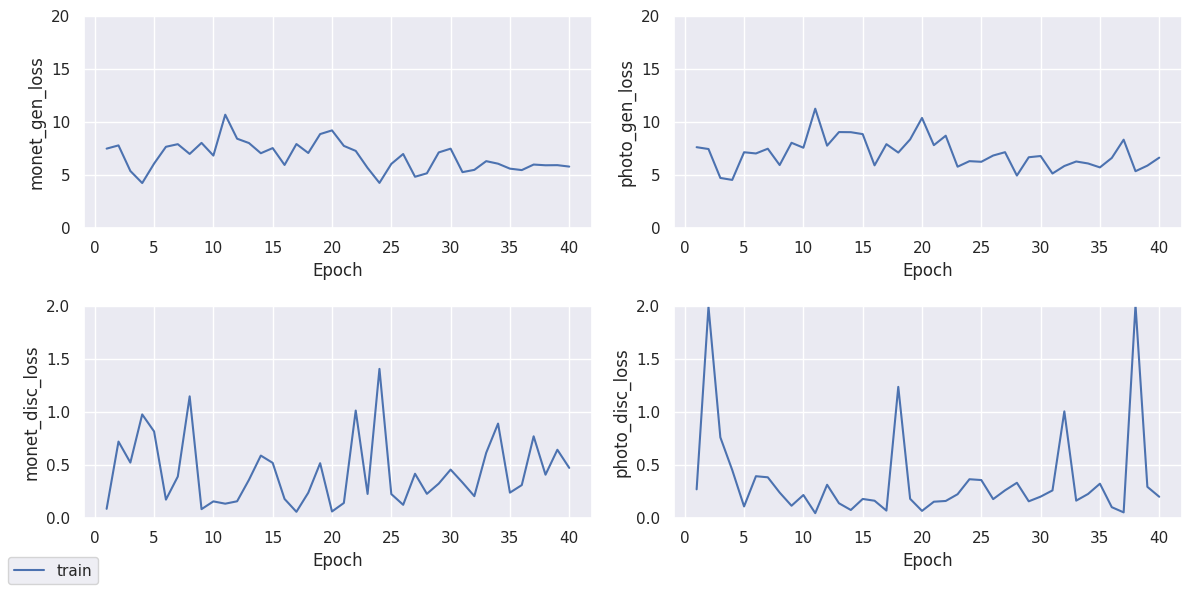

In [28]:
plot_results(chart_df)

In [29]:
# Save results as CSV for later comparison
now = datetime.now()
date_time = now.strftime("%Y%m%d%H%M%S")

chart_df.to_csv('./cyclegan_model_' + date_time + '.csv', 
                index=False, quoting=csv.QUOTE_ALL)

### 5.4 - Displaying Images

I generated several monet-style images based on input images for visualization purposes. Although these images would not deceive anyone into believing that they are genuine Monet paintings, the model did a reasonably decent job of generating convincing fake images, which underscores the effectiveness of CycleGAN.

The generated images provide insight into the model's ability to capture the essence of Monet's style and reproduce it in new, unique images. While there is always room for improvement, these generated images demonstrate the potential of CycleGAN for producing visually appealing and authentic-looking monet-style images.

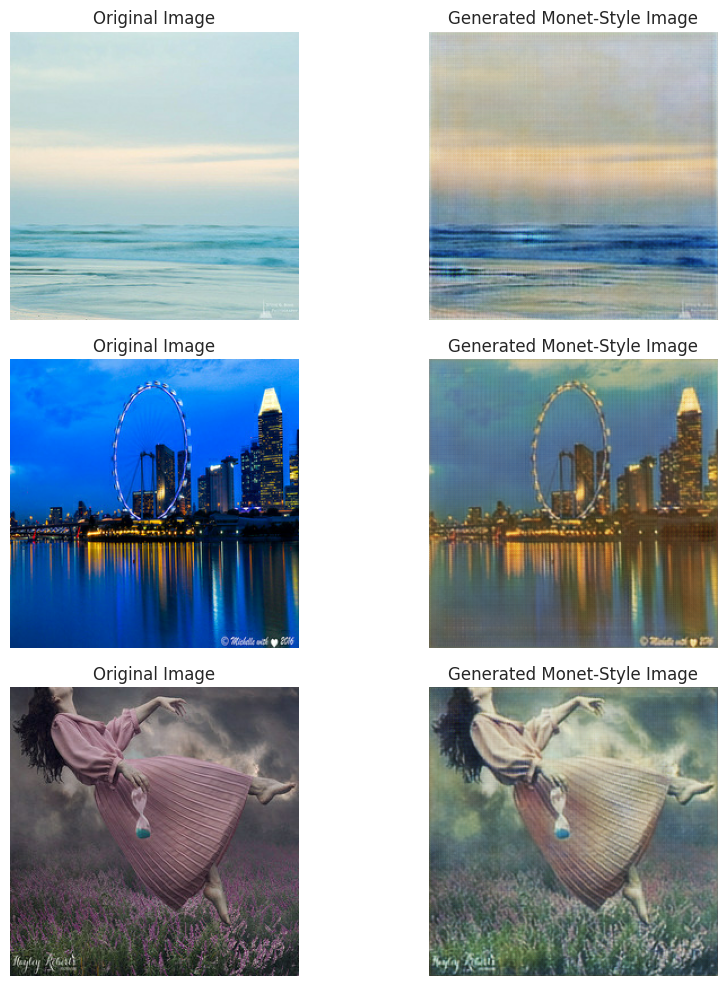

In [37]:
num_samples = 3
photo_samples = photo_dataset.take(num_samples)

# rows = int(num_samples / 2)
# cols = 4
rows = num_samples
cols = 2

_, ax = plt.subplots(rows, cols, figsize=(10, 10))

# for i in range(0, int(num_samples / 2)):
for i in range(0, num_samples):

    sample_image = next(iter(photo_samples))
    sample_image_gen = monet_generator(sample_image)

    ax[i, 0].set_title('Original Image')
    ax[i, 0].imshow(sample_image[0] * 0.5 + 0.5)
    ax[i, 0].axis('off')

    ax[i, 1].set_title('Generated Monet-Style Image')
    ax[i, 1].imshow(sample_image_gen[0] * 0.5 + 0.5)
    ax[i, 1].axis('off')

    # sample_image = next(iter(photo_samples))
    # sample_image_gen = monet_generator(sample_image)

    # ax[i, 2].set_title('Original Image')
    # ax[i, 2].imshow(sample_image[0] * 0.5 + 0.5)
    # ax[i, 2].axis('off')

    # ax[i, 3].set_title('Generated Monet-Style Image')
    # ax[i, 3].imshow(sample_image_gen[0] * 0.5 + 0.5)
    # ax[i, 3].axis('off')    

    # Padding between subplots and labels
    plt.tight_layout(pad=1)

None

### 5.5 - Result Submission

The purpose of this code is to generate a submission file that can be used to obtain the final MiFID score for my model on the original Kaggle competition. The file will contain the predictions made by the optimized model on the test dataset, which is not available during training.

> * **Note:** The code is commented out to prevent accidental execution.

In [31]:
# %%time

# ! mkdir ../images

# print(f'Total Images: {len(list(photo_dataset))}')

# i = 1

# for img in photo_dataset:
#     prediction = monet_generator(img, training=False)[0].numpy()
#     prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
#     im = PIL.Image.fromarray(prediction)
#     im.save("../images/" + str(i) + ".jpg")
#     i += 1
    
#     if i % 100 == 0:
#         print(str(i) + ' ', end='')

In [32]:
# %%time
# shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

## 6 - Conclusion

In conclusion, this project provided an interesting and educational opportunity to explore the inner workings of GANs, and I am satisfied with the results given that my MiFID score falls within the median range of all participants in the competition.

However, I must admit that I did not enjoy working on this project as much as I had hoped. I found Tensorflow and Keras to be challenging libraries to work with, and while there is ample documentation available online, much of it is written in a technical language that can be difficult for someone new to GANs to understand.

Furthermore, the time required to iterate and test new ideas was often prohibitively long, even with the use of TPUs. Waiting nearly 40 minutes to train a new model and submit the results, only to find that the changes did not produce the desired results, was a discouraging experience.

Finally, while I am glad to have gained experience in GANs through this project, I personally find other areas of deep learning, such as image classification, text recognition, and sentiment analysis, to be more interesting and engaging.

### 6.1 Lessons Learned and Areas for Improvement

* Mastering GANs requires significant time and effort to understand the concepts and become proficient with tools like Tensorflow and Keras. The learning curve can be steep, especially for beginners in the field.

* Data preparation is crucial for GANs, as the quality and consistency of the input images directly affect the quality of the generated output. While pre-processing can help, it's essential to ensure that the training data is representative of the desired output.

* Iterating and testing new models is time-consuming and resource-intensive, particularly when dealing with high-resolution images. Access to powerful hardware like TPUs can help speed up the process, but it's not always available or affordable for everyone.

* Despite having metrics like MiFID to evaluate the performance of the model, visual inspection of the generated images is still necessary. This introduces subjectivity to the process and requires the user to have a good understanding of the desired output and the limitations of the model.

* GANs are notorious for their instability during training, which means that the generator and discriminator losses can be highly unstable and fluctuate rapidly. This requires careful monitoring of the training process to avoid issues such as mode collapse or vanishing gradients. That is something I experienced myself with my project.

### 6.2 - Steps that Did Not Work

* Changing the activation function of the final layer from tanh to relu: based on my research, I thought this is because tanh can cause saturation and wash out the image details, whereas relu can better preserve image details and enhance the color contrast. In the end, the result was quite the opposite and the final images were washed out and with little contrast. 

* Applying instance normalization to all downsampling and upsampling layers: instance normalization can help reduce style inconsistencies between the input and output images and improve the overall quality of the generated image. However, instance normalization may not be appropriate for all datasets, and the effect of normalization may vary depending on the type of data being used. In my case, instance normalization was clearly not the best choice for all the layers as it decreased my MiFID score.

* Using spectral normalization to generator/discriminator: spectral normalization is a technique that can improve the stability of GANs by limiting the Lipschitz constant of the discriminator. One can apply spectral normalization to the discriminator's convolutional layers to prevent them from learning large weights. In my case, I was not able to use this technique at all as it produced several errors that I was unable to troubleshoot.

* Using a patchGAN: instead of predicting a single scalar output, one could have the discriminator output a matrix of values, where each value corresponds to whether a particular patch of the input image is real or fake. This is known as a PatchGAN, and it can provide more fine-grained feedback to the generator. In my case, I was not able to use this technique at all as it produced several errors that I was unable to troubleshoot.



In [33]:
# Check Variables
# %whos